# ***Data Processing***

V. 1.12

In [6]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import pylab as pl
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

Basic conversion to types after loading in the data from the csv. Only notable thing is that we are removing any budget data from movies that are made outside the US as their data isnt in dollars.

In [8]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


In [15]:
#Cleaning Rating
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)]
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})
movies["Rating"].value_counts()

R          11056
PG-13       5809
PG          4880
Unrated     3999
G           1053
NC-17         48
Name: Rating, dtype: int64

In [17]:
#Cleaning Year
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [191]:
#Calculating Profit/Loss for each movie
movies["Profit"] = movies["Gross US"]+movies["Gross WW"]- movies["Budget"]
movies["Status"]= np.where(movies['Profit']>1, True, False)
movies["Status"].value_counts()

True     14442
False     4978
Name: Status, dtype: int64

Cleaning up some of the columns

In [21]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies["Genres"] = movies["Genres"].str.replace("'",'')
movies["Actors"] = movies["Actors"].str.replace('[','')
movies["Actors"] = movies["Actors"].str.replace(']','')
movies["Actors"] = movies["Actors"].str.replace("'",'')
movies["Director"] = movies["Director"].str.replace('[','')
movies["Director"] = movies["Director"].str.replace(']','')
movies["Director"] = movies["Director"].str.replace("'",'')
movies["Production Company"] = movies["Production Company"].str.replace('[','')
movies["Production Company"] = movies["Production Company"].str.replace(']','')
movies["Production Company"] = movies["Production Company"].str.replace("'",'')
movies["Language"] = movies["Language"].str.replace('[','')
movies["Language"] = movies["Language"].str.replace(']','')
movies["Language"] = movies["Language"].str.replace("'",'')
# movies.head()

In [23]:
indexNames = movies[ (movies['Year'] == 0) & (movies['Rating'] == 'Unrated')&(movies['Budget'] != -1) ].index
# Delete these row indexes from dataFrame
movies.drop(indexNames , inplace=True)

In [26]:
g = (movies.Genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genre'))
g.index = g.index.droplevel(1)
g["genre"] = g["genre"].str.replace(' ','')
g["genre"] = g["genre"].str.replace('}','')
# m=movies.join(g)
movies=pd.concat([movies, g], axis=1)
movies.head().T

ValueError: Shape of passed values is (18, 425671), indices imply (18, 109735)

In [27]:
genre_count = movies['genre'].value_counts().sort_index()
genre_count

'Action'             79
'Action']            10
'Adventure'         889
'Adventure']         20
'Animation'           6
'Biography'         240
'Biography']         53
'Comedy'            812
'Comedy']           151
'Crime'             884
'Crime']            170
'Documentary'         1
'Documentary']        3
'Drama'            2346
'Drama']            728
'Family'            623
'Family']           179
'Fantasy'           589
'Fantasy']          315
'History'           314
'History']          115
'Horror'            475
'Horror']           168
'Music'             187
'Music']            204
'Musical'            98
'Musical']          124
'Mystery'           683
'Mystery']          158
'News'                4
                   ... 
['Crime']             1
['Documentary'      274
['Documentary']       4
['Drama'           1411
['Drama']           391
['Family'            22
['Family']            1
['Fantasy'           51
['Fantasy']           1
['History'            9
['History']     

In [28]:
drop_geners = ['Musical' ,'Sport', 'History', 'Music','News', 'Reality-TV', 'Talk-Show' , '' ] #Removing TV shows/reality/sport
movies=movies[~movies['genre'].isin(drop_geners)]
movies["genre"].value_counts()

'Drama'            2346
'Thriller']        2293
['Comedy'          2145
['Action'          1787
'Romance']         1497
['Drama'           1411
'Adventure'         889
'Crime'             884
'Comedy'            812
'Drama']            728
'Mystery'           683
['Crime'            658
'Family'            623
'Fantasy'           589
'actor']            578
['Adventure'        526
'Sci-Fi']           521
['Biography'        503
'Romance'           483
'Horror'            475
'Sci-Fi'            436
['Drama']           391
['Comedy']          367
['Horror'           345
['Animation'        330
'Fantasy']          315
'History'           314
'Sport']            307
'War']              301
['Documentary'      274
                   ... 
'Action']            10
['Action']            9
['Musical'            9
['History'            9
'Western'             8
['Sci-Fi']            7
'Animation'           6
[]                    6
'Short'               5
['Reality-TV'         5
['Documentary'] 

In [29]:
movies.info()
movies.to_excel('Test.xlsx')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26785 entries, 0 to 9836
Data columns (total 17 columns):
Name                  26785 non-null object
Year                  26785 non-null float64
Genres                26785 non-null object
Rating                26785 non-null object
Duration_Minutes      26785 non-null float64
Actors                26785 non-null object
Director              26785 non-null object
Average_Rating        26785 non-null float64
Budget                26785 non-null float64
Opening Weekend       15616 non-null float64
Gross US              26785 non-null float64
Gross WW              26785 non-null float64
Language              26337 non-null object
Production Company    26785 non-null object
genre                 26785 non-null object
Profit                26785 non-null float64
Status                26785 non-null object
dtypes: float64(8), object(9)
memory usage: 3.7+ MB


In [30]:
movies.isnull().sum()

Name                      0
Year                      0
Genres                    0
Rating                    0
Duration_Minutes          0
Actors                    0
Director                  0
Average_Rating            0
Budget                    0
Opening Weekend       11169
Gross US                  0
Gross WW                  0
Language                448
Production Company        0
genre                     0
Profit                    0
Status                    0
dtype: int64

In [31]:
# movies["Language"].value_counts()

Filling NA with median value

In [32]:
# def fill_nan(col):
#     movies[col] = movies[col].fillna(movies[col].median())

# cols = list(movies.columns)
# fill_nan(cols)

In [33]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company', 'genre', 'Profit',
       'Status'],
      dtype='object')

In [34]:
movies.Name.value_counts() #multiple movies with same name ..but each was made in different year with different cast
df=movies.groupby(['Name'], as_index=False).size()
df.to_frame()
df.to_excel('test1.xlsx')

# Visualization

In [35]:
# create a histogram of duration, choosing an “appropriate” number of bins
movies['Duration_Minutes'].plot(kind='hist', bins=10)

In [36]:
movies['Duration_Minutes'].plot(kind='box')

Count how many movies have average ratings :

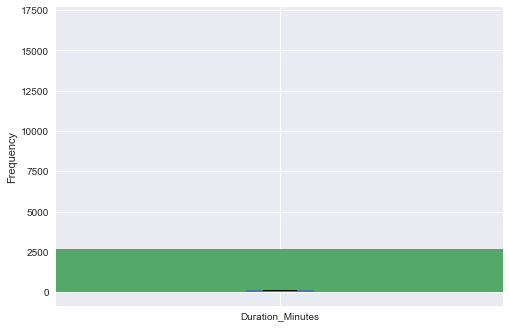

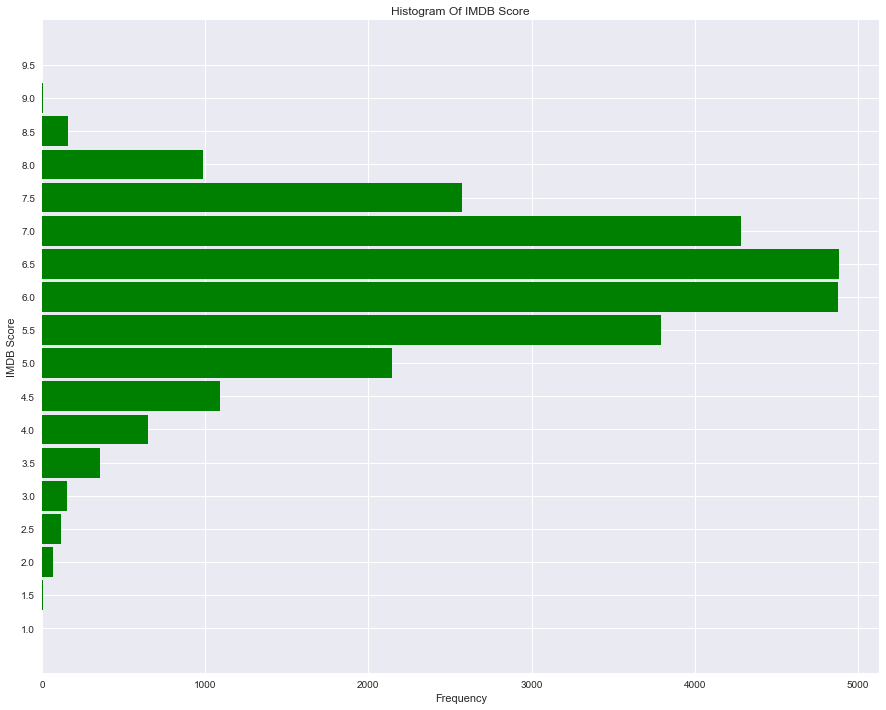

In [37]:
# movies[['Average_Rating' ,'Name']].groupby('Average_Rating').count()
imdbScore=[[]]
x=[]

for i in pl.frange(1,9.5,.5):
    imdbScore.append(len(movies.Average_Rating[(movies.Average_Rating>=i) & (movies.Average_Rating<i+.5)]))
    x.append(i)

del(imdbScore[0])

plt.figure(figsize=(15,12))
plt.title("Histogram Of IMDB Score")
plt.ylabel("IMDB Score")
plt.xlabel('Frequency')
plt.barh(x,imdbScore,height=.45 ,color='green')
plt.yticks(x)
plt.show()

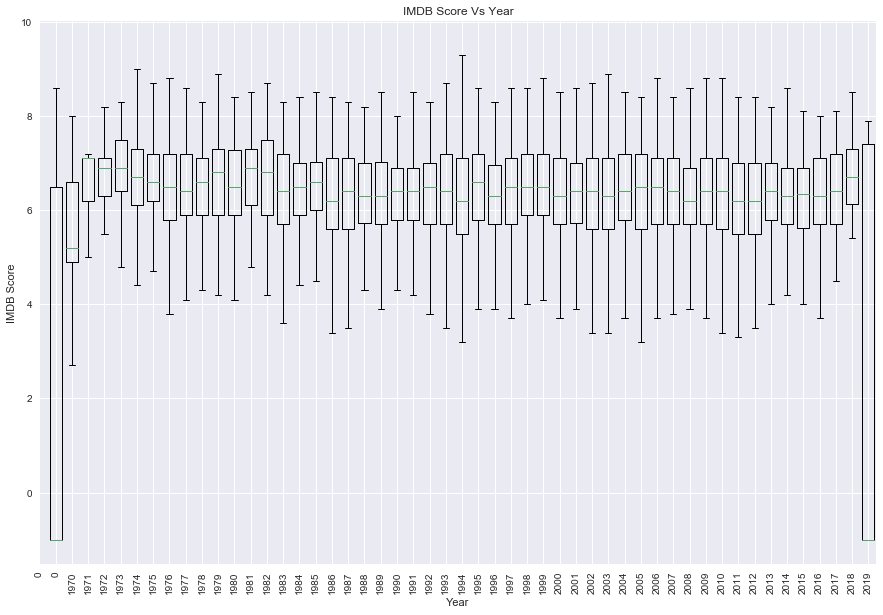

In [38]:
data=movies.dropna()
year=(movies.Year.unique()).astype(int)
year=sorted(year)

yearImdbScore=[]
numOfMovieByYear=[]

for i in year:
    tmp=movies.Average_Rating[movies.Year==i]
    yearImdbScore.append(tmp)
    numOfMovieByYear.append(len(tmp))



plt.figure(figsize=(15,10))
plt.title("IMDB Score Vs Year")
plt.ylabel("IMDB Score")
plt.xlabel('Year')
plt.boxplot(yearImdbScore,widths=.75)
year=list(np.insert(year,0,0))
plt.xticks(range(len(year)),year,rotation=90,fontsize=10)
plt.show()


Top Director VS Their Movie imdb rating

In [39]:
director=list(movies.Director.unique())
df=pd.DataFrame(columns=['director','directorScoreMean','directorImdbScore','directorMovieNUm'])

for i in director:
    tmp=list(movies.Average_Rating[movies.Director==i])
    if len(tmp)>1:
         df=df.append({'director': i,'directorScoreMean': sum(tmp)/len(tmp),'directorImdbScore': tmp,'directorMovieNUm' :len(tmp)},ignore_index=True)
    
tmp=(df.sort_values(['directorScoreMean'],ascending=False)).head(25)
directorByMeanScore=list(tmp.director)
directorByMeanScore.reverse()
ScoreByMeanScore=list(tmp.directorImdbScore)
ScoreByMeanScore.reverse()


tmp=(df.sort_values(['directorMovieNUm'],ascending=False)).head(25)
directorByMovieNum =list(tmp.director)
directorByMovieNum.reverse()
ScoreByMovieNum=list(tmp.directorImdbScore)
ScoreByMovieNum.reverse()

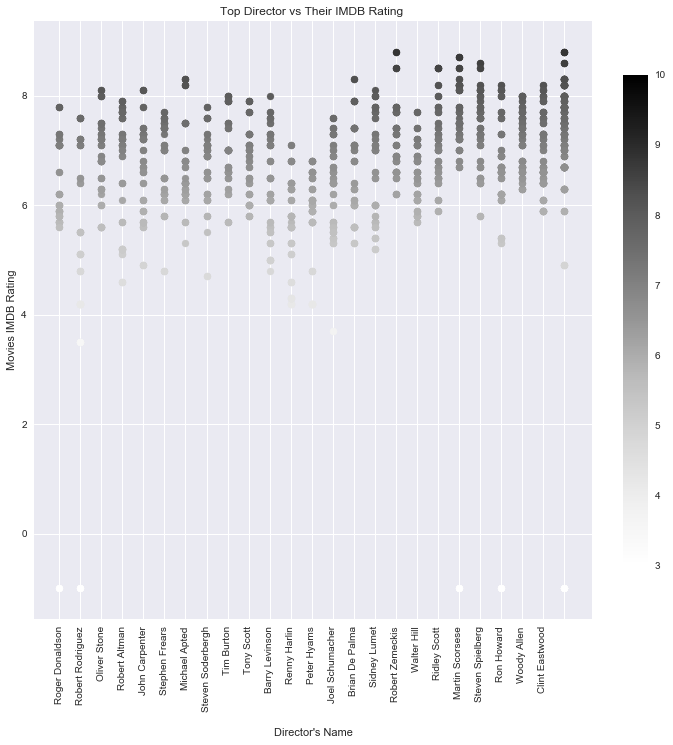

In [40]:
#directorByMovieNum
plt.figure(figsize=(11,11))
for i in range(len(directorByMovieNum)):
    for j in ScoreByMovieNum[i]:
        plt.scatter(i,j,c=j,vmin=3,vmax=10)


#tmp=plt.scatter(c=ScoreByMovieNum)
plt.colorbar(fraction=.04)
plt.title("Top Director vs Their IMDB Rating ")
plt.ylabel('Movies IMDB Rating')
plt.xlabel("\nDirector's Name")
plt.xticks(range(25),directorByMovieNum,rotation=90)

plt.show()

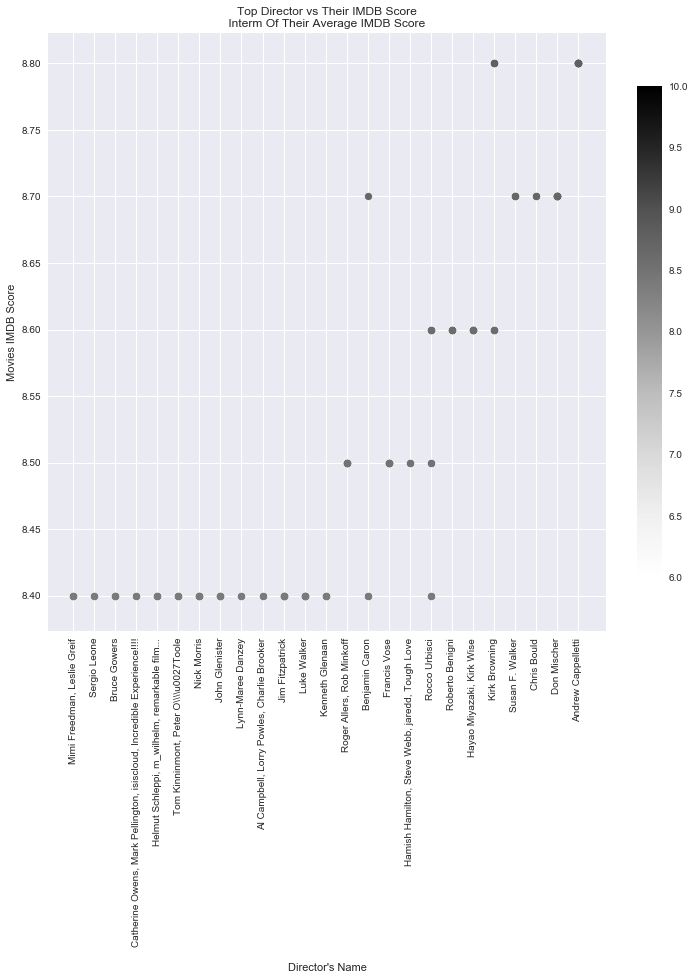

In [41]:
#directorByMeanScore
plt.figure(figsize=(11,11))
for i in range(len(directorByMeanScore)):
    for j in ScoreByMeanScore[i]:
        plt.scatter(i,j,c=j,vmin=6,vmax=10)

plt.xticks(range(25),directorByMeanScore,rotation=90)
plt.title("Top Director vs Their IMDB Score\n Interm Of Their Average IMDB Score ")
plt.ylabel('Movies IMDB Score')
plt.xlabel("\nDirector's Name")
plt.colorbar(fraction=.04)
plt.show()

In [42]:
# use a visualization to display that same data, including a title and x and y labels
movies[['Rating' ,'Name']].groupby('Rating').count().plot(kind='bar', title='Content Rating Visualization')
plt.xlabel('Content Rating')
plt.ylabel('Title Count')

In [43]:
# calculate the average star rating for movies 2 hours or longer,
# and compare that with the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', movies[movies['Duration_Minutes'] >= 120]['Average_Rating'].mean(), 
 '\nAvg. star rating for movies shorter than 2 hours: ', movies[movies['Duration_Minutes'] < 120]['Average_Rating'].mean())

Avg. star rating for movies 2 hours or longer:  6.998810310641102 
Avg. star rating for movies shorter than 2 hours:  6.009021846624135


In [44]:
# use a visualization to detect whether there is a relationship between duration and star rating
movies.boxplot(column='Duration_Minutes', by='Average_Rating');

In [45]:
movies[['Profit','genre']].groupby('genre')

In [46]:
# visualize the relationship between content rating and duration
movies.boxplot(column='Duration_Minutes', by='Rating')

Check for Duplicacy

In [47]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = movies[movies['Name'].isin(movies[movies.duplicated(['Name'])]['Name'])]
result.sort_values('Name')

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,-1.0,-1.0,English,"CapitolFilms, AramidEntertainmentFund, CarolBa...",'Drama'],-1.0,Failure
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,-1.0,-1.0,English,"CapitolFilms, AramidEntertainmentFund, CarolBa...",['Comedy',-1.0,Failure
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",'Drama',85614108.0,Success
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",'Romance'],85614108.0,Success
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",['Comedy',85614108.0,Success
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",['Comedy',98034595.0,Success
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",'Family',98034595.0,Success
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",'Fantasy',98034595.0,Success
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",'Sci-Fi'],98034595.0,Success
3426,...and justice for all.,1979.0,"Crime, Drama, Thriller",R,119.0,"Al Pacino, Jack Warden, John Forsythe, Lee Str...",Norman Jewison,7.4,-1.0,NaN,33300000.0,-1.0,English,ColumbiaPicturesCorporation,'Drama',33300000.0,Success


In [48]:
# calculate the average star rating for each genre, but only include genres with at least 10 movies
genres = movies['Genres'].value_counts()[movies['Genres'].value_counts() > 10].index
movies[movies['Genres'].isin(genres)].groupby('Genres')['Average_Rating'].mean()

Genres
Action, Adventure                                             6.469231
Action, Adventure, Biography, Drama, History, Romance, War    6.150000
Action, Adventure, Comedy                                     5.625000
Action, Adventure, Comedy, Crime                              5.942857
Action, Adventure, Comedy, Crime, Romance, Thriller           6.100000
Action, Adventure, Comedy, Drama, Family, Fantasy, Musical    6.080000
Action, Adventure, Comedy, Family                             4.866667
Action, Adventure, Comedy, Family, Fantasy, Sci-Fi            5.133333
Action, Adventure, Comedy, Family, Romance                    5.833333
Action, Adventure, Comedy, Family, Sci-Fi                     4.962500
Action, Adventure, Comedy, Fantasy, Sci-Fi, Thriller          5.250000
Action, Adventure, Comedy, Horror, Sci-Fi, Thriller           3.942857
Action, Adventure, Comedy, Romance                            6.066667
Action, Adventure, Comedy, Sci-Fi                             6.288889

In [49]:
# Make a function which clean the data
def repp(string):
    return string.replace("'","").replace(",",",")[:-1]
#Apply that function to every entry    
movies_series = movies['Actors'].apply(repp)
#Declare a list to store the split values
actors_list = []
for movie_actors in movies_series:
    actors_list.append([e.strip() for e in movie_actors.split(',')])
#Declare a dictionary and see if the actor name key exist and then count accordingly.
actor_dict = {}
for actor in actors_list:
    for a in actor:
        if a in actor_dict:
            actor_dict[a] +=1
        else:
            actor_dict[a] = 1

actor_dict

{'John Travolta': 115,
 'Uma Thurman': 66,
 'Samuel L. Jackson': 177,
 'Bruce Willi': 12,
 'Andrew Garfield': 19,
 'Emma Stone': 37,
 'Jamie Foxx': 50,
 'Paul Giamatt': 13,
 'Tim Robbins': 77,
 'Morgan Freeman': 122,
 'Bob Gunton': 12,
 'William Sadle': 3,
 'Mark Hamill': 23,
 'Harrison Ford': 112,
 'Carrie Fisher': 25,
 'Alec Guinnes': 4,
 'Michael J. Fox': 61,
 'Christopher Lloyd': 59,
 'Lea Thompson': 28,
 'Crispin Glove': 6,
 'Emilio Estevez': 56,
 'Judd Nelson': 15,
 'Molly Ringwald': 20,
 'Ally Sheed': 2,
 'Sean Astin': 25,
 'Josh Brolin': 64,
 'Jeff Cohen': 3,
 'Corey Feldma': 6,
 'Jodie Foster': 75,
 'Anthony Hopkins': 159,
 'Lawrence A. Bonney': 3,
 'Kasi Lemmon': 7,
 'Sam Neill': 77,
 'Laura Dern': 25,
 'Jeff Goldblum': 54,
 'Richard Attenboroug': 3,
 'Matthew Broderick': 83,
 'Jeremy Irons': 64,
 'James Earl Jones': 54,
 'Whoopi Goldber': 9,
 'Brad Pitt': 109,
 'Kevin Spacey': 83,
 'Andrew Kevin Walke': 4,
 'Tom Hanks': 125,
 'Tim Allen': 53,
 'Don Rickles': 5,
 'Jim Varne':

In [50]:
#Sorted list of Actors
import operator
actor_movie_count = sorted(actor_dict.items(), key=operator.itemgetter(1))
actor_movie_count

[('Thomas Mann', 1),
 ('Oliver Cooper', 1),
 ('Jonathan Daniel Brown', 1),
 ('Dax Flam', 1),
 ('Jacob Lofland', 1),
 ('Robert LaSard', 1),
 ('Will Brill', 1),
 ('Brahm Vaccarell', 1),
 ('Isaac Leyva', 1),
 ('Ellen Sandweiss', 1),
 ('Richard DeManincor', 1),
 ('Betsy Bake', 1),
 ('Lindsay Loha', 1),
 ('David Spad', 1),
 ('Stephen Merchant', 1),
 ('Wes Bentle', 1),
 ('David Herman', 1),
 ('Ajay Naid', 1),
 ('Jon Abrahams', 1),
 ('Carmen Electr', 1),
 ('Efren Ramirez', 1),
 ('Aaron Ruel', 1),
 ('Bill Hade', 1),
 ('Martin Stringe', 1),
 ('Bee Vang', 1),
 ('Christopher Carley', 1),
 ('Ahney He', 1),
 ('Adelaide Clemens', 1),
 ('Kit Harington', 1),
 ('Steve Carel', 1),
 ('Lucy Walter', 1),
 ('Kevin McKid', 1),
 ('Wiley Wiggins', 1),
 ('Justin Chon', 1),
 ('Jonathan Keltz', 1),
 ('Sarah Wrigh', 1),
 ('Aasif Mandv', 1),
 ('David A.R. White', 1),
 ('Andrea Logan White', 1),
 ('Gerald R. Mole', 1),
 ('Antony Acker', 1),
 ('Mark Barret', 1),
 ('Pamela Anderso', 1),
 ('June Squibb', 1),
 ('Jonny C

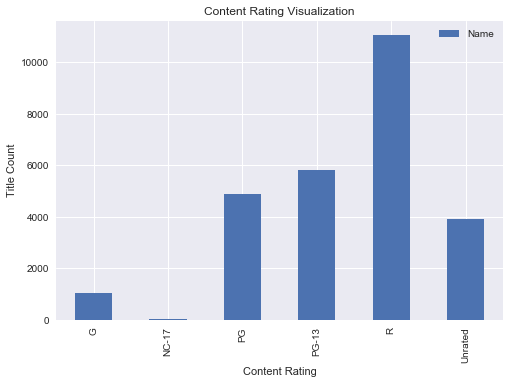

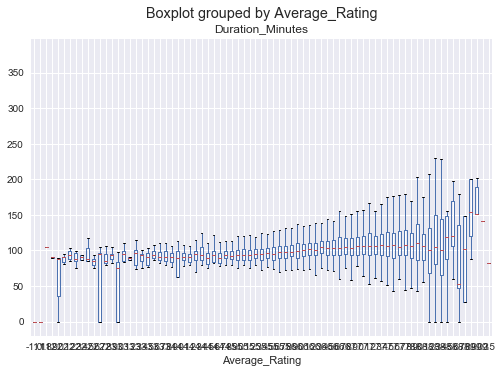

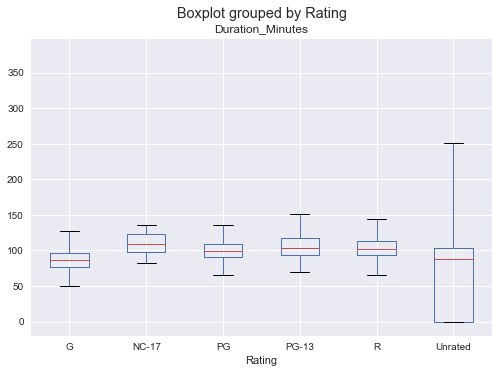

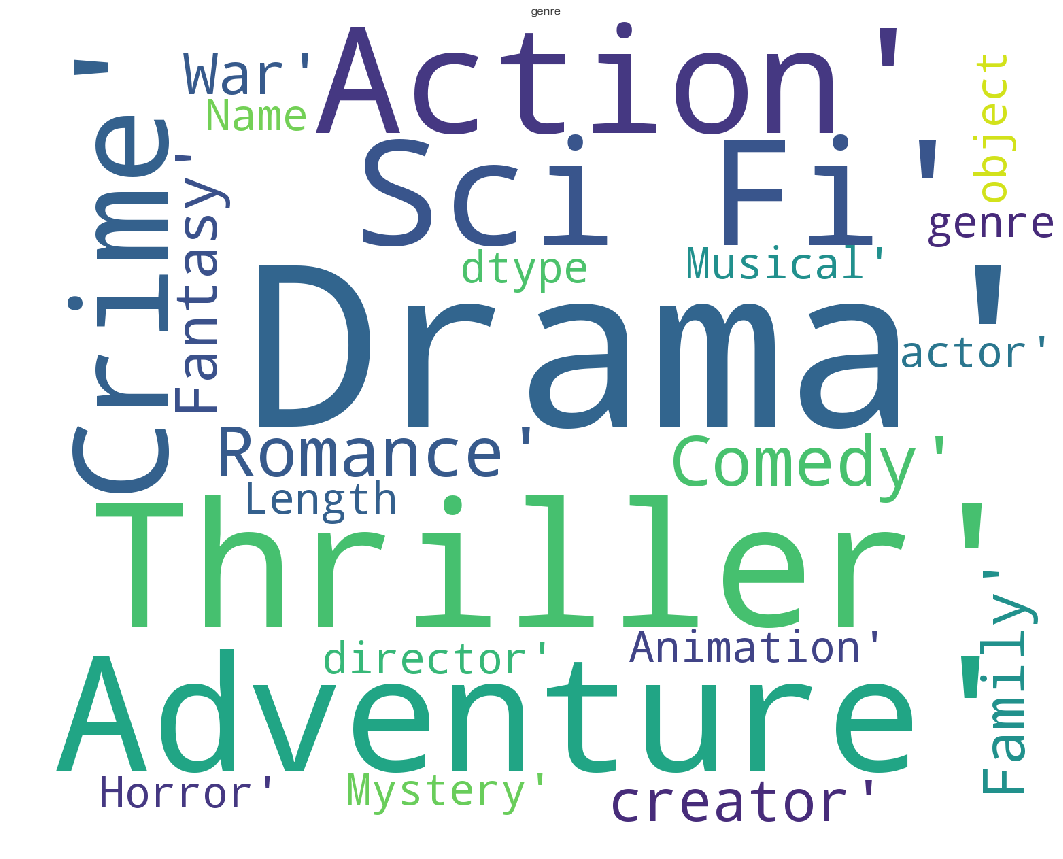

In [51]:
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(movies['genre']))
plt.subplots(figsize=(20,15))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('genre')
plt.axis('off')
plt.show()

In [52]:
movies["genre"].value_counts()

'Drama'            2346
'Thriller']        2293
['Comedy'          2145
['Action'          1787
'Romance']         1497
['Drama'           1411
'Adventure'         889
'Crime'             884
'Comedy'            812
'Drama']            728
'Mystery'           683
['Crime'            658
'Family'            623
'Fantasy'           589
'actor']            578
['Adventure'        526
'Sci-Fi']           521
['Biography'        503
'Romance'           483
'Horror'            475
'Sci-Fi'            436
['Drama']           391
['Comedy']          367
['Horror'           345
['Animation'        330
'Fantasy']          315
'History'           314
'Sport']            307
'War']              301
['Documentary'      274
                   ... 
'Action']            10
['Action']            9
['Musical'            9
['History'            9
'Western'             8
['Sci-Fi']            7
'Animation'           6
[]                    6
'Short'               5
['Reality-TV'         5
['Documentary'] 

In [53]:
# movies.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# # plt.title('TOP 10 Directors OF MOVIES')

In [54]:
# movies.Actors.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# plt.title('TOP 10 Actors OF MOVIES')

In [55]:
# movies["Year"].value_counts().to_frame()

In [56]:
g=movies.groupby('Year')
g.count().head(10)

,Name,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
Year,,,,,,,,,,,,,,,,
0.0,878,878,878,878,878,878,878,878,0,878,878,438,878,878,878,878
1970.0,29,29,29,29,29,29,29,29,0,29,29,29,29,29,29,29
1971.0,8,8,8,8,8,8,8,8,0,8,8,8,8,8,8,8
1972.0,133,133,133,133,133,133,133,133,6,133,133,133,133,133,133,133
1973.0,397,397,397,397,397,397,397,397,16,397,397,397,397,397,397,397
1974.0,328,328,328,328,328,328,328,328,5,328,328,328,328,328,328,328
1975.0,337,337,337,337,337,337,337,337,12,337,337,337,337,337,337,337
1976.0,344,344,344,344,344,344,344,344,15,344,344,343,344,344,344,344
1977.0,341,341,341,341,341,341,341,341,23,341,341,341,341,341,341,341


In [57]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
9029,Yanni Live! The Concert Event,2006.0,Music,Unrated,82.0,"Charlie Adams, Michelle Amato, Kristen Autry, ...","George Veras, ProReviews, Excellent music, exc...",9.5,-1.0,NaN,-1.0,-1.000000e+00,English,,['Music'],-1.000000e+00,Failure
2,The Shawshank Redemption,1994.0,Drama,R,142.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,9.3,25000000.0,727326.0,28341469.0,5.850000e+07,English,CastleRockEntertainment,['Drama'],6.184147e+07,Success
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",Francis Ford Coppola,9.0,13000000.0,NaN,57300000.0,-1.000000e+00,"English, Italian, Spanish, Latin, Sicilian","ParamountPictures, TheCoppolaCompany",'Drama'],4.430000e+07,Success
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",Francis Ford Coppola,9.0,13000000.0,NaN,57300000.0,-1.000000e+00,"English, Italian, Spanish, Latin, Sicilian","ParamountPictures, TheCoppolaCompany",['Crime',4.430000e+07,Success
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"English, Mandarin","WarnerBros., LegendaryEntertainment, Syncopy",'Thriller'],1.354417e+09,Success
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"English, Mandarin","WarnerBros., LegendaryEntertainment, Syncopy",'Drama',1.354417e+09,Success
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"English, Mandarin","WarnerBros., LegendaryEntertainment, Syncopy",'Crime',1.354417e+09,Success
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Christopher Nolan,9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"English, Mandarin","WarnerBros., LegendaryEntertainment, Syncopy",['Action',1.354417e+09,Success
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,2.139288e+08,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",'Drama'],3.138575e+08,Success
9253,Strangers: The Story of a Mother and Daughter,1979.0,"Drama, actor",Unrated,88.0,"Bette Davis, Gena Rowlands, Ford Rainey, Donal...",Milton Katselas,8.9,-1.0,NaN,-1.0,-1.000000e+00,English,Chris/RoseProductions,['Drama',-1.000000e+00,Failure


In [58]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,-1.0,-1.0,English,"EminenceProductions, ClothFilm",['Action',-4000002.0,Failure
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,-1.0,-1.0,English,"EminenceProductions, ClothFilm",'Fantasy',-4000002.0,Failure
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",Justin Price,2.5,4000000.0,NaN,-1.0,-1.0,English,"EminenceProductions, ClothFilm",'Horror'],-4000002.0,Failure
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...","Eli Dorsey, Eli Dorsey, Bezenby, Kind of okay,...",2.0,-1.0,NaN,-1.0,-1.0,English,,['Action',-1.0,Failure
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...","Eli Dorsey, Eli Dorsey, Bezenby, Kind of okay,...",2.0,-1.0,NaN,-1.0,-1.0,English,,'Horror'],-1.0,Failure


In [59]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [60]:
#top 5 high revenue movies
Sortedrevenue.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,678815482.0,2.048710e+09,English,"MarvelStudios, JasonRobertsProductions, SouthP...",['Action',2.406525e+09,Success
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,678815482.0,2.048710e+09,English,"MarvelStudios, JasonRobertsProductions, SouthP...",'Sci-Fi'],2.406525e+09,Success
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Anthony Russo, Joe Russo",8.5,321000000.0,257698183.0,678815482.0,2.048710e+09,English,"MarvelStudios, JasonRobertsProductions, SouthP...",'Adventure',2.406525e+09,Success
9408,Justice League,2017.0,"Action, Adventure, Fantasy, Sci-Fi",PG-13,120.0,"Ben Affleck, Gal Gadot, Jason Momoa, Ezra Miller",Zack Snyder,6.5,300000000.0,93842239.0,229024295.0,6.147297e+08,"English, Irish, Russian, Icelandic","WarnerBros., RatPacEntertainment, DCEntertainment",['Action',5.437540e+08,Success
460,Pirates of the Caribbean: At World\'s End,2007.0,"Action, Adventure, Fantasy",PG-13,169.0,"Johnny Depp, Orlando Bloom, Keira Knightley, G...",Gore Verbinski,7.1,300000000.0,139802190.0,309420425.0,9.634204e+08,English,"WaltDisneyPictures, JerryBruckheimerFilms, Sec...",'Fantasy'],9.728408e+08,Success


In [61]:
m= Sortedrevenue.query('(Budget > 500)')
print('number of movies with more than half million revenue:')
len(m)

number of movies with more than half million revenue:


16797

In [62]:
n= Sortedrevenue.query('(Budget < 500)')
print('number of movies with less than half million revenue:')
len(n)

number of movies with less than half million revenue:


9988

In [63]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26785 entries, 0 to 9836
Data columns (total 17 columns):
Name                  26785 non-null object
Year                  26785 non-null float64
Genres                26785 non-null object
Rating                26785 non-null object
Duration_Minutes      26785 non-null float64
Actors                26785 non-null object
Director              26785 non-null object
Average_Rating        26785 non-null float64
Budget                26785 non-null float64
Opening Weekend       15616 non-null float64
Gross US              26785 non-null float64
Gross WW              26785 non-null float64
Language              26337 non-null object
Production Company    26785 non-null object
genre                 26785 non-null object
Profit                26785 non-null float64
Status                26785 non-null object
dtypes: float64(8), object(9)
memory usage: 4.3+ MB


In [64]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(m['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN HIGH REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [65]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(n['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN LOW REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [66]:
numeric_features=movies._get_numeric_data().columns.values.tolist()
numeric_features

['Year',
 'Duration_Minutes',
 'Average_Rating',
 'Budget',
 'Opening Weekend',
 'Gross US',
 'Gross WW',
 'Profit']

# Correlation heatmap

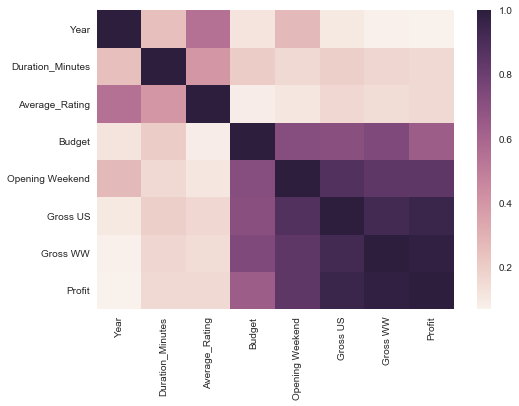

In [67]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())
plt.show()

In [68]:
correlation=movies.corr()
correlation

,Year,Duration_Minutes,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Profit
Year,1.000000,0.250221,0.550141,0.118657,0.276515,0.099206,0.074290,0.069705
Duration_Minutes,0.250221,1.000000,0.403308,0.206159,0.157781,0.194036,0.168620,0.161313
Average_Rating,0.550141,0.403308,1.000000,0.090101,0.110868,0.166648,0.148631,0.160199
Budget,0.118657,0.206159,0.090101,1.000000,0.716860,0.714167,0.741750,0.643643
Opening Weekend,0.276515,0.157781,0.110868,0.716860,1.000000,0.882590,0.843457,0.841195
Gross US,0.099206,0.194036,0.166648,0.714167,0.882590,1.000000,0.924103,0.951351
Gross WW,0.074290,0.168620,0.148631,0.741750,0.843457,0.924103,1.000000,0.983724
Profit,0.069705,0.161313,0.160199,0.643643,0.841195,0.951351,0.983724,1.000000


In [69]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",['Crime',313857524.0,Success
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",'Drama'],313857524.0,Success
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",['Action',711836256.0,Success
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",'Adventure',711836256.0,Success
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",'Sci-Fi'],711836256.0,Success


# Checking that we can replace Rating with Monitary Value

We are going to check to see if each rating has a different enough distribution to justify replacing each Rating with their respective mean. This is going to be done by a two sample t test cross comparing each Rating with eachother, making 7 t tests in total. The actaul replacement will be done in the prediction alogrthm. 

In [420]:
#Need to change all movie ratings that are NC-17 to Unrated
movies["Rating"] = movies["Rating"].replace('NC-17', 'Unrated')
#Removing all movies that dont have a Gross US
movies = movies[movies['Gross US'] > 0]
movies = movies[movies['Budget'] > 0]

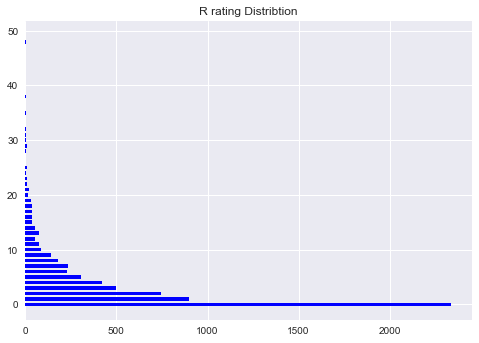

Mean Value:  27702840.657108176


In [421]:
#Graphing R rating vs Gross Earning distrubition
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingR = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(groupingR))
plt.barh(y_pos , groupingR["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

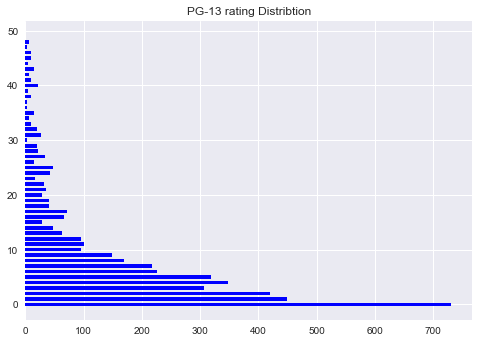

Mean Value:  65290623.96313466


In [422]:
#Graphing PG13 rating vs Gross Earning distrubition
PG13 = movies[movies["Rating"] == 'PG-13']
PG13 = PG13[PG13["Gross US"] > 0]
PG13 = PG13.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG13 = PG13.groupby(pd.cut(PG13["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG13))
plt.barh(y_pos , groupingPG13["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", PG13["Gross US"].mean())

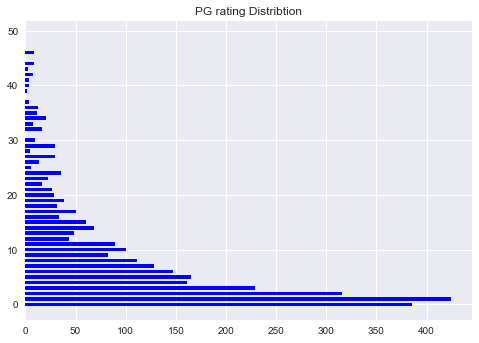

Mean Value:  63587625.23492994


In [423]:
#Graphing PG rating vs Gross Earning distrubition
PG = movies[movies["Rating"] == 'PG']
PG = PG[PG["Gross US"] > 0]
PG = PG.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG = PG.groupby(pd.cut(PG["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG))
plt.barh(y_pos , groupingPG["Gross US"], 1/1.5, color="blue")
plt.title("PG rating Distribtion")
plt.show()
print("Mean Value: ", PG["Gross US"].mean())

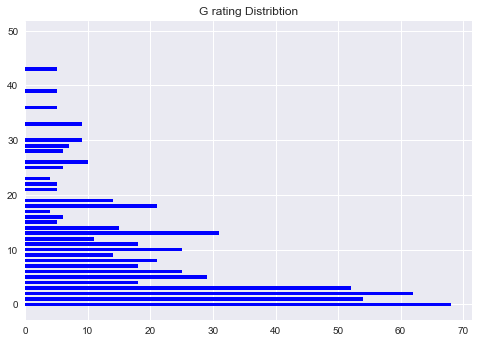

Mean Value:  75617321.94798657


In [424]:
#Graphing G rating vs Gross Earning distrubition
G = movies[movies["Rating"] == 'G']
G = G[G["Gross US"] > 0]
G = G.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingG = G.groupby(pd.cut(G["Gross US"], groups)).count()
y_pos = np.arange(len(groupingG))
plt.barh(y_pos , groupingG["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", G["Gross US"].mean())

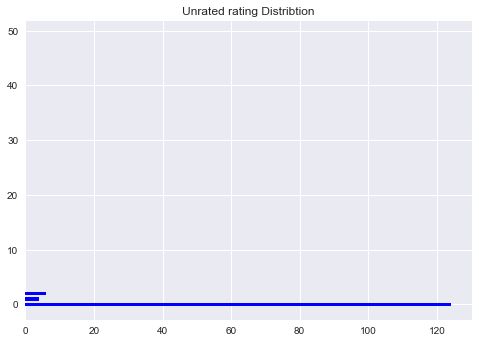

Mean Value:  1813863.7388059702


In [425]:
#Graphing Unrated rating vs Gross Earning distrubition
UN = movies[movies["Rating"] == 'Unrated']
UN = UN[UN["Gross US"] > 0]
UN = UN.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingUN = UN.groupby(pd.cut(UN["Gross US"], groups)).count()
y_pos = np.arange(len(groupingUN))
plt.barh(y_pos , groupingUN["Gross US"], 1/1.5, color="blue")
plt.title("Unrated rating Distribtion")
plt.show()
print("Mean Value: ", UN["Gross US"].mean())

In [426]:
#Checking to see if teh ratings are statiscally different are statistically different
print("R-PG13: ", stats.ttest_ind(R["Gross US"], PG13["Gross US"], equal_var = False))
print("R-PG: ", stats.ttest_ind(R["Gross US"], PG["Gross US"], equal_var = False))
print("R-G: ", stats.ttest_ind(R["Gross US"], G["Gross US"], equal_var = False))
print("PG13-PG: ", stats.ttest_ind(PG13["Gross US"], PG["Gross US"], equal_var = False))
print("PG13-G: ", stats.ttest_ind(PG13["Gross US"], G["Gross US"], equal_var = False))
print("PG-G: ", stats.ttest_ind(PG["Gross US"], G["Gross US"], equal_var = False))
print("UN-R: ", stats.ttest_ind(UN["Gross US"], R["Gross US"], equal_var = False))
print("UN-PG13: ", stats.ttest_ind(UN["Gross US"], PG13["Gross US"], equal_var = False))
print("UN-PG: ", stats.ttest_ind(UN["Gross US"], PG["Gross US"], equal_var = False))
print("UN-G: ", stats.ttest_ind(UN["Gross US"], G["Gross US"], equal_var = False))

R-PG13:  Ttest_indResult(statistic=-27.085986327018908, pvalue=6.3714020565619387e-152)
R-PG:  Ttest_indResult(statistic=-25.563484379855172, pvalue=4.3441347731067797e-133)
R-G:  Ttest_indResult(statistic=-14.343712872514276, pvalue=1.7781370314492624e-40)
PG13-PG:  Ttest_indResult(statistic=0.91091693458639289, pvalue=0.36236930609749307)
PG13-G:  Ttest_indResult(statistic=-2.8996493605771034, pvalue=0.0038388061450660509)
PG-G:  Ttest_indResult(statistic=-3.3718937373942839, pvalue=0.00078243448398593188)
UN-R:  Ttest_indResult(statistic=-45.54347410021203, pvalue=2.7497539307132957e-233)
UN-PG13:  Ttest_indResult(statistic=-46.696768525882646, pvalue=0.0)
UN-PG:  Ttest_indResult(statistic=-44.903471324962531, pvalue=0.0)
UN-G:  Ttest_indResult(statistic=-22.171446601667153, pvalue=2.8632386376445437e-80)


Statiscally non of these values with high accuracy are equal to eachother. This allows us to say that each rating has statiscally different value. Lets now replace the Rating with the value of the mean of the rating to signify the value that the rating has upon the movie.

In [427]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,genre,Profit,Status
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",['Crime',313857524.0,True
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",'Drama'],313857524.0,True
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",['Action',711836256.0,True
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",'Adventure',711836256.0,True
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",'Sci-Fi'],711836256.0,True


# PREDICTION

In [472]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [473]:
movies.fillna(value=0,axis=1,inplace=True)
print(movies.set_index(['Budget','Opening Weekend','Gross US'])
         .stack()
         .reset_index(name='value')
         )

             Budget  Opening Weekend     Gross US             level_3  \
0         8000000.0        9311882.0  107928762.0                Name   
1         8000000.0        9311882.0  107928762.0                Year   
2         8000000.0        9311882.0  107928762.0              Genres   
3         8000000.0        9311882.0  107928762.0              Rating   
4         8000000.0        9311882.0  107928762.0    Duration_Minutes   
5         8000000.0        9311882.0  107928762.0              Actors   
6         8000000.0        9311882.0  107928762.0            Director   
7         8000000.0        9311882.0  107928762.0      Average_Rating   
8         8000000.0        9311882.0  107928762.0            Gross WW   
9         8000000.0        9311882.0  107928762.0            Language   
10        8000000.0        9311882.0  107928762.0  Production Company   
11        8000000.0        9311882.0  107928762.0               genre   
12        8000000.0        9311882.0  107928762.0  

In [474]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14920 entries, 0 to 9835
Data columns (total 17 columns):
Name                  14920 non-null object
Year                  14920 non-null float64
Genres                14920 non-null object
Rating                14920 non-null object
Duration_Minutes      14920 non-null float64
Actors                14920 non-null object
Director              14920 non-null object
Average_Rating        14920 non-null float64
Budget                14920 non-null float64
Opening Weekend       14920 non-null float64
Gross US              14920 non-null float64
Gross WW              14920 non-null float64
Language              14920 non-null object
Production Company    14920 non-null object
genre                 14920 non-null object
Profit                14920 non-null float64
Status                14920 non-null bool
dtypes: bool(1), float64(8), object(8)
memory usage: 1.9+ MB


In [475]:
features = ['Rating', 'Genres']
target = ['Profit']
PROFIT_MARIGINE = 1

In [476]:
train, test = train_test_split(movies,test_size=0.30)


In [477]:
#Fill the training and test data with require information
train_x = train[features] 
train_y = train[target]
train_gross = train['Profit']
test_x = test[features]
test_y = test[target]

Here we are going to change the Rating value to the mean value of the Gross US made by all movies in that rating. Please not that we do NOT take the movies in the test array into the mean value of the Gross US. Furthermore we only replace the movies with the mean value of the train movies. This means that any test movie rating are replace with the training moviie's mean gross US for that rating.

In [478]:
R = train_gross[train_x["Rating"] == 'R']
PG13 = train_gross[train_x["Rating"] == 'PG-13']
PG = train_gross[train_x["Rating"] == 'PG']
G = train_gross[train_x["Rating"] == 'G']
UN = train_gross[train_x["Rating"] == 'Unrated']
#a baseline for the value of movies made in that rating
train_x["Rating"] = train_x["Rating"].replace('R', R.mean())
train_x["Rating"] = train_x["Rating"].replace('PG-13', PG13.mean())
train_x["Rating"] = train_x["Rating"].replace('PG', PG.mean())
train_x["Rating"] = train_x["Rating"].replace('G', G.mean())
train_x["Rating"] = train_x["Rating"].replace('Unrated', UN.mean())
train_x["Rating"] = train_x["Rating"].astype(float)
#a baseline for the value of movies made in that rating
test_x["Rating"] = test_x["Rating"].replace('R', R.mean())
test_x["Rating"] = test_x["Rating"].replace('PG-13', PG13.mean())
test_x["Rating"] = test_x["Rating"].replace('PG', PG.mean())
test_x["Rating"] = test_x["Rating"].replace('G', G.mean())
test_x["Rating"] = test_x["Rating"].replace('Unrated', UN.mean())
test_x["Rating"] = test_x["Rating"].astype(float)

In [479]:
# calculate the average Gross US for each genre, but only include genres with at least 10 movies
genreList = train_x['Genres'].unique()
unknownGenres = test_x[~(test_x['Genres'].isin(genreList))]['Genres'].unique()

genreValues = pd.DataFrame()
genreValues["List"] = genreList
genreValues["Value"] = genreList
for g in genreList:
    genreValues.loc[genreValues['List'] == g, "Value"] = train_gross[train_x['Genres'] == g].mean()
for g in genreList:
    train_x["Genres"] = train_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
    test_x["Genres"] = test_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
avg = train_gross.mean()
for g in unknownGenres:
    test_x["Genres"] = test_x["Genres"].replace(g, avg)

In [480]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_x_std = pd.DataFrame(sc.fit_transform(train_x),columns=features)
test_x_std = pd.DataFrame(sc.transform(test_x), columns=features)


In [481]:
train_x_std.head(2)

,Rating,Genres
0,-1.070233,-0.416980
1,0.728982,-0.750913


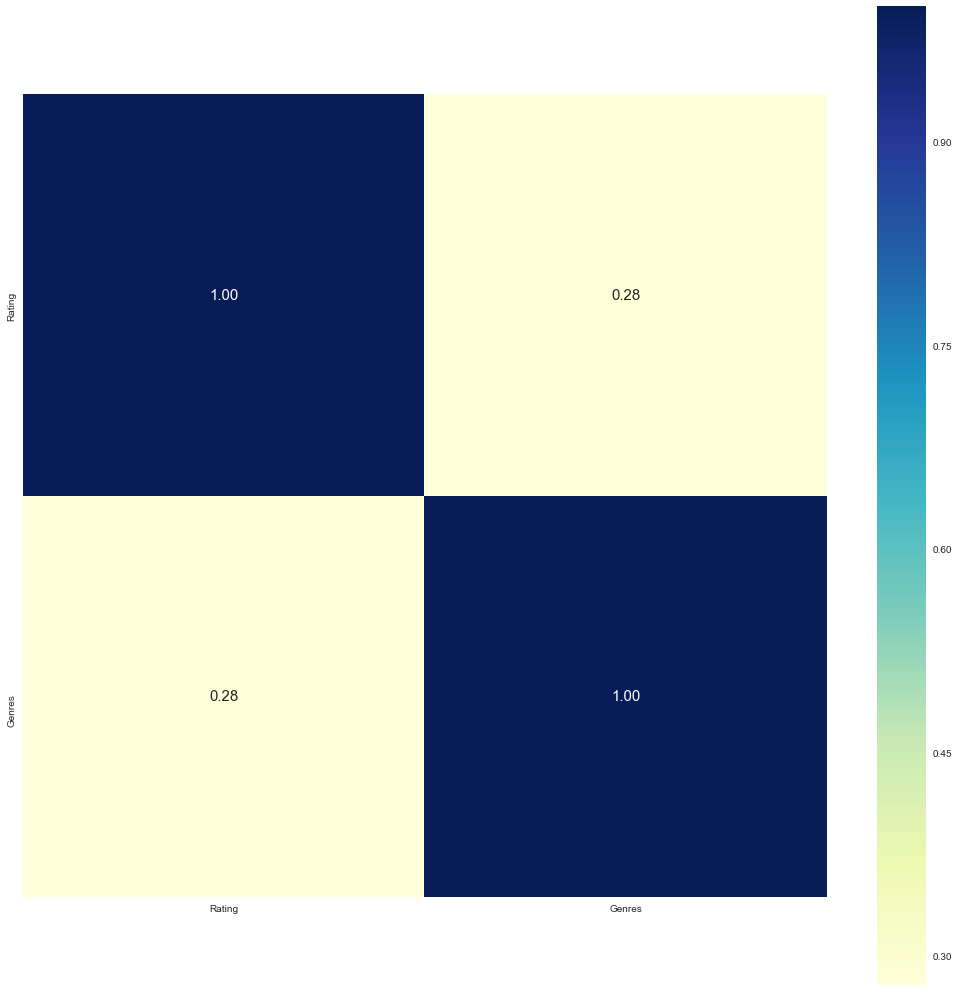

In [482]:
corr = train_x_std.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
            cmap= 'YlGnBu')
plt.show()

In [483]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_x_std,train_y)
predicted_rating = model.predict(test_x_std)

In [484]:
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0] > PROFIT_MARIGINE):
        predicted_rating[i][0] = 1
    else:
        predicted_rating[i][0] = 0
test_y = np.where(test_y['Profit']> PROFIT_MARIGINE, True, False)


In [485]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_x_std, train_y, cv=5)
print("Linear regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Linear regression accuracy: 0.45 (+/- 0.06)


In [489]:
#Calculate score of the model
from sklearn import metrics 
r2score  = metrics.r2_score(test_y,predicted_rating)
print('R2 score is: {}'.format(round(r2score,2)))
accuracy = 0
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0]  == test_y[i]):
        accuracy = accuracy + 1
print(accuracy/len(predicted_rating))


R2 score is: -0.34
0.7008489722966935
[[ 1.]
 [ 0.]
 [ 0.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]


In [501]:
clf = svm.SVC(gamma=0.001, C=100)
train_y = np.where(train_y['Profit']> PROFIT_MARIGINE, True, False)
clf.fit( train_x, train_y)
predictions = clf.predict(test_x)
confuse = metrics.confusion_matrix(test_y, predictions)
print(confuse)
accuracy = (confuse[0][0] + confuse[1][1])/(confuse[0][0] + confuse[1][0] + confuse[0][1] + confuse[1][1])
print("Accuracy of SVC: ", accuracy)

[[ 687  829]
 [ 234 2726]]
Accuracy pf SVC:  0.762511170688


In [498]:

high_score_data= movies.loc[movies['Gross US']>=3] #only count of movies with score>= 3.0
sns.countplot(high_score_data['Gross US'],label='Gross US')
plt.show()

[[ 687  829]
 [ 234 2726]]


In [499]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
print(test_y.shape)
scores = cross_val_score(rf, test_x_std,np.ravel(test_y), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Maximum score in cross valuation is: %0.2f'%(scores.max()))

(4476,)
Accuracy: 0.73 (+/- 0.02)
Maximum score in cross valuation is: 0.74


In [500]:
ser = pd.Series(rf.feature_importances_,index=features) #feature importance
ser.sort_values(ascending=False,inplace=True)
ser.plot(kind='bar')

NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.